# CGAN-LSTM para Generación de Señales ECG Sintéticas

Este notebook implementa una **Conditional Generative Adversarial Network (CGAN)** con **LSTM** para generar señales ECG sintéticas condicionadas por tipo de arritmia.

## Arquitectura:
- **Generador**: LSTM multi-capa que captura dependencias temporales
- **Discriminador**: LSTM que clasifica señales reales vs sintéticas
- **Condicionamiento**: Embeddings de clase para controlar el tipo de arritmia generada

## 1. Importación de Librerías

In [1]:
import os
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Carga del Dataset ECG

Cargamos el dataset preprocesado que contiene señales ECG de diferentes tipos de arritmias.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, Adam

## 3. Preparación de Datos

### 3.1 Exploración y Preprocesamiento

In [ ]:
import pickle

path_db = "./ECG_DATASET/dataset_ekg.pkl"

with open(path_db, "rb") as f:
    dataset = pickle.load(f)

print("Clases disponibles:", dataset.keys())

print("\nForma de cada clase:")    print(f"{key}: {value.shape}")
for key, value in dataset.items():

{'NSR': array([[-0.06451476, -0.05951476, -0.02951476, ...,  0.13548524,
          0.13048524,  0.11548524],
        [ 0.24548524,  0.25048524,  0.24048524, ...,  0.34048524,
          0.33548524,  0.31548524],
        [ 0.13048524,  0.12548524,  0.11048524, ..., -0.20451476,
         -0.20451476, -0.20451476],
        ...,
        [-0.46451476, -0.46451476, -0.46451476, ..., -0.59451476,
         -0.58951476, -0.58951476],
        [-0.53451476, -0.51451476, -0.53451476, ..., -0.51451476,
         -0.44451476, -0.40451476],
        [ 0.51548524,  0.50548524,  0.50548524, ...,  0.21048524,
          0.20048524,  0.18548524]], shape=(283, 3600)),
 'VT': array([[ 0.10787069,  0.08787069,  0.08787069, ...,  0.01287069,
         -0.00212931,  0.01787069],
        [-0.31212931, -0.29712931, -0.27212931, ...,  0.82787069,
          0.84787069,  0.86787069],
        [ 0.01287069,  0.00787069,  0.00287069, ...,  0.04787069,
          0.06787069,  0.10287069],
        ...,
        [ 0.17287069, 

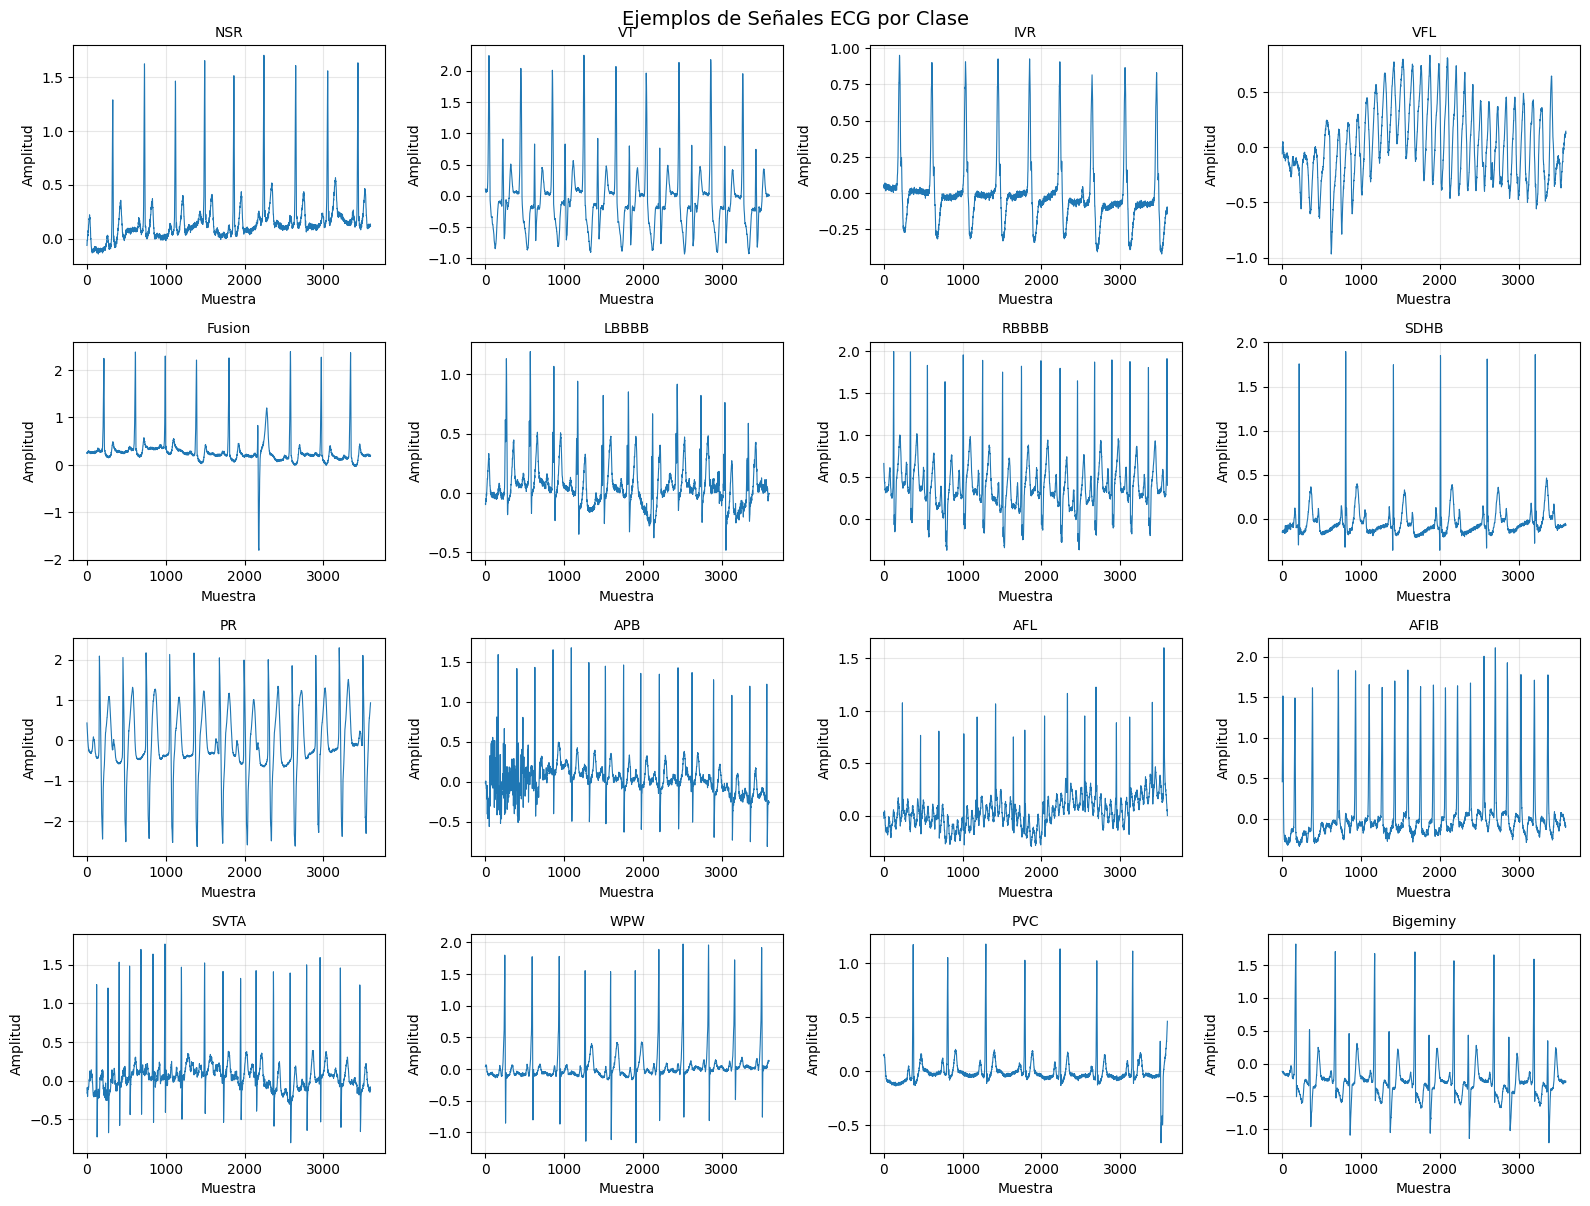

In [7]:
class_names = list(dataset.keys())

# Visualizar algunas señales de ejemplo
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, class_name in enumerate(class_names[:16]):
    signal = dataset[class_name][0]  # Primera señal de cada clase
    axes[idx].plot(signal, linewidth=0.8)
    axes[idx].set_title(f"{class_name}", fontsize=10)
    axes[idx].set_xlabel("Muestra")
    axes[idx].set_ylabel("Amplitud")
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.suptitle("Ejemplos de Señales ECG por Clase", fontsize=14, y=1.001)
plt.show()

### 3.2 Dataset Personalizado en PyTorch

Creamos un Dataset personalizado que retorna señales normalizadas y sus etiquetas de clase.

In [10]:
from torch.utils.data import Dataset, DataLoader

class ECGDataset(Dataset):
    """Dataset personalizado para señales ECG"""
    
    def __init__(self, data_dict, class_to_idx, normalize=True):
        """
        Args:
            data_dict: Diccionario {clase: array de señales}
            class_to_idx: Diccionario {nombre_clase: índice}
            normalize: Si True, normaliza las señales a [-1, 1]
        """
        self.signals = []
        self.labels = []
        
        for class_name, signals in data_dict.items():
            class_idx = class_to_idx[class_name]
            for signal in signals:
                self.signals.append(signal)
                self.labels.append(class_idx)
        
        self.signals = np.array(self.signals, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)
        
        # Normalización opcional
        if normalize:
            # Normalizar cada señal independientemente a [-1, 1]
            for i in range(len(self.signals)):
                min_val = self.signals[i].min()
                max_val = self.signals[i].max()
                if max_val > min_val:
                    self.signals[i] = 2 * (self.signals[i] - min_val) / (max_val - min_val) - 1
        
        print(f"Dataset creado: {len(self.signals)} señales, {len(np.unique(self.labels))} clases")
    
    def __len__(self):
        return len(self.signals)
    
    def __getitem__(self, idx):
        signal = torch.FloatTensor(self.signals[idx]).unsqueeze(0)  # (1, seq_len)
        label = torch.LongTensor([self.labels[idx]])
        return signal, label

# Crear mapeo de clase a índice
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

# Crear dataset
ecg_dataset = ECGDataset(dataset, class_to_idx, normalize=True)

# Crear DataLoader
batch_size = 64
dataloader = DataLoader(ecg_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

print(f"Batch size: {batch_size}")
print(f"Número de batches: {len(dataloader)}")

Dataset creado: 1000 señales, 17 clases
Batch size: 64
Número de batches: 15


## 4. Arquitectura del Modelo CGAN-LSTM

### 4.1 Generador con LSTM

El generador toma ruido aleatorio + embedding de clase y genera una señal ECG.

In [12]:
import torch.nn as nn

class LSTMGenerator(nn.Module):
    """Generador basado en LSTM para señales ECG"""
    
    def __init__(self, latent_dim, num_classes, seq_length, embedding_dim=50, 
                 hidden_dim=256, num_layers=2, dropout=0.3):
        """
        Args:
            latent_dim: Dimensión del vector de ruido
            num_classes: Número de clases (tipos de arritmia)
            seq_length: Longitud de la señal a generar
            embedding_dim: Dimensión del embedding de clase
            hidden_dim: Dimensión oculta del LSTM
            num_layers: Número de capas LSTM
            dropout: Tasa de dropout
        """
        super(LSTMGenerator, self).__init__()
        
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.seq_length = seq_length
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Embedding para las clases
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)
        
        # Capa de entrada: combina ruido + embedding de clase
        self.input_dim = latent_dim + embedding_dim
        
        # Proyección inicial
        self.fc_input = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim)
        )
        
        # LSTM multi-capa
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Capa de salida: genera la señal
        self.fc_output = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Tanh()  # Salida en [-1, 1]
        )
    
    def forward(self, noise, labels):
        """
        Args:
            noise: (batch_size, latent_dim)
            labels: (batch_size, 1)
        Returns:
            generated_signals: (batch_size, 1, seq_length)
        """
        batch_size = noise.size(0)
        
        # Embedding de las etiquetas
        label_emb = self.label_embedding(labels.squeeze(1))  # (batch_size, embedding_dim)
        
        # Concatenar ruido + embedding
        gen_input = torch.cat([noise, label_emb], dim=1)  # (batch_size, latent_dim + embedding_dim)
        
        # Proyección inicial
        x = self.fc_input(gen_input)  # (batch_size, hidden_dim)
        
        # Expandir para LSTM: repetir hidden_dim a lo largo de seq_length
        x = x.unsqueeze(1).repeat(1, self.seq_length, 1)  # (batch_size, seq_length, hidden_dim)
        
        # LSTM
        lstm_out, _ = self.lstm(x)  # (batch_size, seq_length, hidden_dim)
        
        # Generar señal punto por punto
        output = self.fc_output(lstm_out)  # (batch_size, seq_length, 1)
        
        # Transponer a formato (batch_size, 1, seq_length)
        output = output.transpose(1, 2)
        
        return output

print("✓ Generador LSTM definido")

✓ Generador LSTM definido


### 4.2 Discriminador con LSTM

El discriminador clasifica si una señal es real o generada, condicionado por la clase.

In [13]:
class LSTMDiscriminator(nn.Module):
    """Discriminador basado en LSTM para señales ECG"""
    
    def __init__(self, num_classes, seq_length, embedding_dim=50, 
                 hidden_dim=256, num_layers=2, dropout=0.3):
        """
        Args:
            num_classes: Número de clases
            seq_length: Longitud de la señal
            embedding_dim: Dimensión del embedding de clase
            hidden_dim: Dimensión oculta del LSTM
            num_layers: Número de capas LSTM
            dropout: Tasa de dropout
        """
        super(LSTMDiscriminator, self).__init__()
        
        self.num_classes = num_classes
        self.seq_length = seq_length
        self.hidden_dim = hidden_dim
        
        # Embedding para las clases
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)
        
        # Proyección del embedding a la longitud de la señal
        self.label_proj = nn.Linear(embedding_dim, seq_length)
        
        # LSTM multi-capa (input: señal + embedding proyectado)
        self.lstm = nn.LSTM(
            input_size=2,  # 1 canal señal + 1 canal embedding
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True  # LSTM bidireccional para mejor contexto
        )
        
        # Capas de clasificación
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 256),  # *2 por bidireccional
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Probabilidad [0, 1]
        )
    
    def forward(self, signal, labels):
        """
        Args:
            signal: (batch_size, 1, seq_length)
            labels: (batch_size, 1)
        Returns:
            validity: (batch_size, 1) - probabilidad de ser real
        """
        batch_size = signal.size(0)
        
        # Embedding de las etiquetas
        label_emb = self.label_embedding(labels.squeeze(1))  # (batch_size, embedding_dim)
        
        # Proyectar embedding a longitud de señal
        label_proj = self.label_proj(label_emb)  # (batch_size, seq_length)
        label_proj = label_proj.unsqueeze(1)  # (batch_size, 1, seq_length)
        
        # Concatenar señal + embedding proyectado
        disc_input = torch.cat([signal, label_proj], dim=1)  # (batch_size, 2, seq_length)
        disc_input = disc_input.transpose(1, 2)  # (batch_size, seq_length, 2)
        
        # LSTM
        lstm_out, (h_n, c_n) = self.lstm(disc_input)  # lstm_out: (batch_size, seq_length, hidden_dim*2)
        
        # Usar el último estado oculto (concatenación de forward y backward)
        # h_n shape: (num_layers*2, batch_size, hidden_dim)
        last_hidden = torch.cat([h_n[-2], h_n[-1]], dim=1)  # (batch_size, hidden_dim*2)
        
        # Clasificación
        validity = self.fc(last_hidden)  # (batch_size, 1)
        
        return validity

print("✓ Discriminador LSTM definido")

✓ Discriminador LSTM definido


## 5. Configuración del Entrenamiento

### 5.1 Hiperparámetros y Dispositivo

In [15]:
import torch

# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")

# Hiperparámetros
latent_dim = 100
num_classes = len(class_names)
seq_length = 3600  # Longitud de cada señal ECG
embedding_dim = 50
hidden_dim = 256
num_layers = 2
dropout = 0.3

lr_g = 0.0002
lr_d = 0.0001
beta1 = 0.5
beta2 = 0.999

num_epochs = 100
sample_interval = 10  # Guardar muestras cada N epochs

print(f"\nHiperparámetros:")
print(f"  Latent dim: {latent_dim}")
print(f"  Número de clases: {num_classes}")
print(f"  Longitud de señal: {seq_length}")
print(f"  Hidden dim: {hidden_dim}")
print(f"  Num layers: {num_layers}")
print(f"  Learning rate G: {lr_g}")
print(f"  Learning rate D: {lr_d}")
print(f"  Epochs: {num_epochs}")

Dispositivo: cuda

Hiperparámetros:
  Latent dim: 100
  Número de clases: 17
  Longitud de señal: 3600
  Hidden dim: 256
  Num layers: 2
  Learning rate G: 0.0002
  Learning rate D: 0.0001
  Epochs: 100


### 5.2 Inicialización de Modelos y Optimizadores

In [17]:
# Inicializar modelos
generator = LSTMGenerator(
    latent_dim=latent_dim,
    num_classes=num_classes,
    seq_length=seq_length,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout
).to(device)

discriminator = LSTMDiscriminator(
    num_classes=num_classes,
    seq_length=seq_length,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout
).to(device)

print(f"\nGenerador:")
print(f"  Parámetros: {sum(p.numel() for p in generator.parameters()):,}")
print(f"\nDiscriminador:")
print(f"  Parámetros: {sum(p.numel() for p in discriminator.parameters()):,}")

# Optimizadores
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, beta2))

# Función de pérdida
adversarial_loss = nn.BCELoss()

print("\n✓ Modelos y optimizadores inicializados")


Generador:
  Parámetros: 1,125,715

Discriminador:
  Parámetros: 2,458,243

✓ Modelos y optimizadores inicializados

✓ Modelos y optimizadores inicializados


## 6. Funciones de Entrenamiento

### 6.1 Función de Entrenamiento por Epoch

In [18]:
def train_epoch(generator, discriminator, dataloader, optimizer_G, optimizer_D, 
                adversarial_loss, device, epoch):
    """
    Entrena el modelo por un epoch
    """
    generator.train()
    discriminator.train()
    
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    epoch_d_real_acc = 0.0
    epoch_d_fake_acc = 0.0
    
    for i, (real_signals, labels) in enumerate(dataloader):
        batch_size = real_signals.size(0)
        
        # Mover a device
        real_signals = real_signals.to(device)
        labels = labels.to(device)
        
        # Etiquetas para adversarial loss
        valid = torch.ones((batch_size, 1), device=device)
        fake = torch.zeros((batch_size, 1), device=device)
        
        # ==================
        # Entrenar Generador
        # ==================
        optimizer_G.zero_grad()
        
        # Generar ruido y señales falsas
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size, 1), device=device)
        gen_signals = generator(z, gen_labels)
        
        # Pérdida del generador (quiere que el discriminador clasifique como real)
        g_loss = adversarial_loss(discriminator(gen_signals, gen_labels), valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        # =======================
        # Entrenar Discriminador
        # =======================
        optimizer_D.zero_grad()
        
        # Pérdida con señales reales
        real_pred = discriminator(real_signals, labels)
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Pérdida con señales falsas
        fake_pred = discriminator(gen_signals.detach(), gen_labels)
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # Pérdida total del discriminador
        d_loss = (d_real_loss + d_fake_loss) / 2
        
        d_loss.backward()
        optimizer_D.step()
        
        # Métricas
        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()
        epoch_d_real_acc += (real_pred > 0.5).float().mean().item()
        epoch_d_fake_acc += (fake_pred < 0.5).float().mean().item()
    
    # Promedios
    num_batches = len(dataloader)
    return {
        'g_loss': epoch_g_loss / num_batches,
        'd_loss': epoch_d_loss / num_batches,
        'd_real_acc': epoch_d_real_acc / num_batches,
        'd_fake_acc': epoch_d_fake_acc / num_batches
    }

print("✓ Función de entrenamiento definida")

✓ Función de entrenamiento definida


### 6.2 Función para Generar y Visualizar Señales

In [19]:
def generate_and_plot_signals(generator, num_classes, idx_to_class, latent_dim, 
                              seq_length, device, epoch, save_dir='generated_samples'):
    """
    Genera y visualiza señales sintéticas para cada clase
    """
    generator.eval()
    
    os.makedirs(save_dir, exist_ok=True)
    
    # Generar una señal por clase
    fig, axes = plt.subplots(4, 5, figsize=(20, 12))
    axes = axes.flatten()
    
    with torch.no_grad():
        for class_idx in range(min(num_classes, 20)):
            z = torch.randn(1, latent_dim, device=device)
            label = torch.LongTensor([[class_idx]]).to(device)
            
            gen_signal = generator(z, label)
            gen_signal = gen_signal.cpu().numpy().squeeze()
            
            axes[class_idx].plot(gen_signal, linewidth=0.8)
            axes[class_idx].set_title(f"{idx_to_class[class_idx]}", fontsize=10)
            axes[class_idx].set_xlabel("Muestra")
            axes[class_idx].set_ylabel("Amplitud")
            axes[class_idx].grid(alpha=0.3)
            axes[class_idx].set_ylim(-1.5, 1.5)
    
    # Ocultar ejes sobrantes
    for idx in range(num_classes, 20):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Señales Generadas - Epoch {epoch}", fontsize=14, y=1.001)
    
    # Guardar
    save_path = os.path.join(save_dir, f'epoch_{epoch:04d}.png')
    plt.savefig(save_path, dpi=100, bbox_inches='tight')
    plt.close()
    
    print(f"  → Muestras guardadas en {save_path}")
    
    generator.train()

print("✓ Función de generación y visualización definida")

✓ Función de generación y visualización definida


## 7. Entrenamiento del Modelo

### 7.1 Loop de Entrenamiento Principal

In [20]:
# Crear mapeo inverso de índice a clase
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

# Historial de entrenamiento
history = {
    'g_loss': [],
    'd_loss': [],
    'd_real_acc': [],
    'd_fake_acc': []
}

print("Iniciando entrenamiento...\n")
print("="*80)

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    
    # Entrenar por un epoch
    metrics = train_epoch(
        generator, discriminator, dataloader,
        optimizer_G, optimizer_D, adversarial_loss,
        device, epoch
    )
    
    # Guardar métricas
    history['g_loss'].append(metrics['g_loss'])
    history['d_loss'].append(metrics['d_loss'])
    history['d_real_acc'].append(metrics['d_real_acc'])
    history['d_fake_acc'].append(metrics['d_fake_acc'])
    
    epoch_time = time.time() - epoch_start
    
    # Imprimir progreso
    print(f"Epoch [{epoch+1:3d}/{num_epochs}] | "
          f"G Loss: {metrics['g_loss']:.4f} | "
          f"D Loss: {metrics['d_loss']:.4f} | "
          f"D Real Acc: {metrics['d_real_acc']:.3f} | "
          f"D Fake Acc: {metrics['d_fake_acc']:.3f} | "
          f"Time: {epoch_time:.2f}s")
    
    # Generar y guardar muestras
    if (epoch + 1) % sample_interval == 0:
        generate_and_plot_signals(
            generator, num_classes, idx_to_class, latent_dim,
            seq_length, device, epoch + 1
        )

total_time = time.time() - start_time
print("\n" + "="*80)
print(f"Entrenamiento completado en {total_time/60:.2f} minutos")
print("="*80)

Iniciando entrenamiento...



OutOfMemoryError: CUDA out of memory. Tried to allocate 4.86 GiB. GPU 0 has a total capacity of 2.00 GiB of which 0 bytes is free. Of the allocated memory 6.90 GiB is allocated by PyTorch, and 493.20 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### 7.2 Visualización de Métricas de Entrenamiento

In [ ]:
# Graficar pérdidas
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pérdidas
axes[0].plot(history['g_loss'], label='Generator Loss', linewidth=2)
axes[0].plot(history['d_loss'], label='Discriminator Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Pérdidas durante el Entrenamiento')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Precisiones
axes[1].plot(history['d_real_acc'], label='D Acc Real', linewidth=2)
axes[1].plot(history['d_fake_acc'], label='D Acc Fake', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Precisión del Discriminador')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Métricas de entrenamiento visualizadas")

## 8. Generación de Señales Sintéticas

### 8.1 Generar Múltiples Señales por Clase

In [ ]:
def generate_synthetic_signals(generator, class_idx, class_name, num_signals, 
                              latent_dim, device):
    """
    Genera múltiples señales sintéticas para una clase específica
    """
    generator.eval()
    
    synthetic_signals = []
    
    with torch.no_grad():
        for i in range(num_signals):
            z = torch.randn(1, latent_dim, device=device)
            label = torch.LongTensor([[class_idx]]).to(device)
            
            gen_signal = generator(z, label)
            gen_signal = gen_signal.cpu().numpy().squeeze()
            synthetic_signals.append(gen_signal)
    
    synthetic_signals = np.array(synthetic_signals)
    print(f"Generadas {num_signals} señales sintéticas para clase '{class_name}'")
    
    return synthetic_signals

# Generar 100 señales sintéticas para cada clase
num_synthetic_per_class = 100
synthetic_dataset = {}

for class_name, class_idx in class_to_idx.items():
    synthetic_signals = generate_synthetic_signals(
        generator, class_idx, class_name, num_synthetic_per_class,
        latent_dim, device
    )
    synthetic_dataset[class_name] = synthetic_signals

print(f"\nDataset sintético completo: {sum(len(v) for v in synthetic_dataset.values())} señales")

### 8.2 Comparación: Señales Reales vs Sintéticas

In [ ]:
# Comparar señales reales vs sintéticas
fig, axes = plt.subplots(6, 6, figsize=(18, 18))

for idx, class_name in enumerate(class_names[:18]):
    row = idx // 6
    col = idx % 6
    
    # Señal real
    real_signal = dataset[class_name][0]
    # Señal sintética
    synthetic_signal = synthetic_dataset[class_name][0]
    
    axes[row*2, col].plot(real_signal, linewidth=0.8, color='blue')
    axes[row*2, col].set_title(f"{class_name} - Real", fontsize=9)
    axes[row*2, col].set_ylim(-1.5, 1.5)
    axes[row*2, col].grid(alpha=0.3)
    
    axes[row*2+1, col].plot(synthetic_signal, linewidth=0.8, color='red')
    axes[row*2+1, col].set_title(f"{class_name} - Sintética", fontsize=9)
    axes[row*2+1, col].set_ylim(-1.5, 1.5)
    axes[row*2+1, col].grid(alpha=0.3)

plt.tight_layout()
plt.suptitle("Comparación: Señales Reales vs Sintéticas", fontsize=14, y=1.001)
plt.savefig('comparison_real_vs_synthetic.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Comparación visualizada")

## 9. Guardar Modelos y Dataset Sintético

### 9.1 Guardar Modelos Entrenados

In [ ]:
# Crear directorio para modelos
os.makedirs('models', exist_ok=True)

# Guardar generador
torch.save({
    'epoch': num_epochs,
    'model_state_dict': generator.state_dict(),
    'optimizer_state_dict': optimizer_G.state_dict(),
    'history': history,
    'config': {
        'latent_dim': latent_dim,
        'num_classes': num_classes,
        'seq_length': seq_length,
        'embedding_dim': embedding_dim,
        'hidden_dim': hidden_dim,
        'num_layers': num_layers,
        'dropout': dropout
    }
}, 'models/generator_cgan_lstm.pth')

# Guardar discriminador
torch.save({
    'epoch': num_epochs,
    'model_state_dict': discriminator.state_dict(),
    'optimizer_state_dict': optimizer_D.state_dict(),
}, 'models/discriminator_cgan_lstm.pth')

print("✓ Modelos guardados en 'models/'")

### 9.2 Guardar Dataset Sintético

In [ ]:
# Guardar dataset sintético
with open('synthetic_ecg_dataset.pkl', 'wb') as f:
    pickle.dump(synthetic_dataset, f)

print("✓ Dataset sintético guardado en 'synthetic_ecg_dataset.pkl'")

# Guardar también el mapeo de clases
with open('class_mapping.pkl', 'wb') as f:
    pickle.dump({
        'class_to_idx': class_to_idx,
        'idx_to_class': idx_to_class,
        'class_names': class_names
    }, f)

print("✓ Mapeo de clases guardado en 'class_mapping.pkl'")

## 10. Función para Cargar y Usar el Modelo

### 10.1 Función de Carga

In [ ]:
def load_generator(checkpoint_path, device='cpu'):
    """
    Carga un generador desde un checkpoint
    """
    checkpoint = torch.load(checkpoint_path, map_location=device)
    config = checkpoint['config']
    
    generator = LSTMGenerator(
        latent_dim=config['latent_dim'],
        num_classes=config['num_classes'],
        seq_length=config['seq_length'],
        embedding_dim=config['embedding_dim'],
        hidden_dim=config['hidden_dim'],
        num_layers=config['num_layers'],
        dropout=config['dropout']
    ).to(device)
    
    generator.load_state_dict(checkpoint['model_state_dict'])
    generator.eval()
    
    print(f"Generador cargado desde {checkpoint_path}")
    print(f"Entrenado por {checkpoint['epoch']} epochs")
    
    return generator, config

# Ejemplo de uso:
# loaded_gen, config = load_generator('models/generator_cgan_lstm.pth', device)

print("✓ Función de carga definida")

### 10.2 Ejemplo de Generación con Modelo Cargado

In [ ]:
# Ejemplo: Generar señales para una clase específica
def generate_ecg_for_class(generator, class_name, class_to_idx, latent_dim, 
                           num_samples=5, device='cpu'):
    """
    Genera señales ECG para una clase específica
    """
    generator.eval()
    class_idx = class_to_idx[class_name]
    
    signals = []
    with torch.no_grad():
        for _ in range(num_samples):
            z = torch.randn(1, latent_dim, device=device)
            label = torch.LongTensor([[class_idx]]).to(device)
            signal = generator(z, label).cpu().numpy().squeeze()
            signals.append(signal)
    
    return np.array(signals)

# Ejemplo de uso:
test_class = 'NSR'
test_signals = generate_ecg_for_class(
    generator, test_class, class_to_idx, latent_dim, num_samples=5, device=device
)

print(f"\nGeneradas {len(test_signals)} señales para clase '{test_class}'")
print(f"Forma de cada señal: {test_signals[0].shape}")

# Visualizar
plt.figure(figsize=(15, 8))
for i, sig in enumerate(test_signals):
    plt.subplot(5, 1, i+1)
    plt.plot(sig, linewidth=0.8)
    plt.title(f"Señal {i+1} - {test_class}")
    plt.ylabel('Amplitud')
    plt.grid(alpha=0.3)
    plt.ylim(-1.5, 1.5)
    if i == 4:
        plt.xlabel('Muestra')

plt.tight_layout()
plt.savefig(f'generated_{test_class}_examples.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Ejemplos de {test_class} generados y visualizados")

---

## Resumen del Modelo CGAN-LSTM

### Arquitectura:
- **Generador**: LSTM multi-capa con embeddings de clase
  - Input: Ruido latente (100D) + Embedding de clase (50D)
  - Hidden: LSTM bidireccional (256 unidades, 2 capas)
  - Output: Señal ECG (1 x seq_length) en rango [-1, 1]

- **Discriminador**: LSTM bidireccional con embeddings de clase
  - Input: Señal ECG + Embedding de clase proyectado
  - Hidden: LSTM bidireccional (256 unidades, 2 capas)
  - Output: Probabilidad de ser real [0, 1]

### Características:
- ✓ Condicionamiento por tipo de arritmia (17 clases)
- ✓ Captura de dependencias temporales con LSTM
- ✓ Generación controlada de señales ECG sintéticas
- ✓ Normalización a [-1, 1] para estabilidad
- ✓ Dropout y BatchNorm para regularización

### Uso:
1. Entrenar el modelo con el dataset real
2. Generar señales sintéticas para cualquier clase
3. Usar para data augmentation o análisis